In [10]:
# Importing the necessary packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import datetime
from math import sqrt
%matplotlib inline

# Packages below needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  2%|▏         | 4/251 [00:00<00:08, 30.33it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


  4%|▍         | 11/251 [00:00<00:08, 28.76it/s]

Ignoring sporadic type error as noise.


 11%|█         | 27/251 [00:00<00:07, 30.99it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 14%|█▍        | 35/251 [00:01<00:06, 31.36it/s]

Ignoring sporadic type error as noise.


 17%|█▋        | 42/251 [00:01<00:06, 30.05it/s]

Ignoring sporadic type error as noise.


 20%|█▉        | 50/251 [00:02<00:18, 10.77it/s]

Ignoring sporadic type error as noise.


 22%|██▏       | 56/251 [00:03<00:21,  9.11it/s]

Ignoring sporadic type error as noise.


 24%|██▍       | 60/251 [00:03<00:21,  8.84it/s]

Ignoring sporadic type error as noise.


 25%|██▌       | 63/251 [00:03<00:19,  9.72it/s]

Ignoring sporadic type error as noise.


 27%|██▋       | 67/251 [00:04<00:19,  9.40it/s]

Ignoring sporadic type error as noise.


 28%|██▊       | 71/251 [00:04<00:19,  9.06it/s]

Ignoring sporadic type error as noise.


 29%|██▉       | 73/251 [00:05<00:21,  8.13it/s]

Ignoring sporadic type error as noise.


 31%|███       | 77/251 [00:05<00:22,  7.87it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 31%|███▏      | 79/251 [00:05<00:20,  8.49it/s]

Ignoring sporadic type error as noise.


 32%|███▏      | 81/251 [00:06<00:21,  7.83it/s]

Ignoring sporadic type error as noise.


 33%|███▎      | 84/251 [00:06<00:22,  7.51it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 35%|███▍      | 87/251 [00:06<00:19,  8.41it/s]

Ignoring sporadic type error as noise.


 36%|███▌      | 90/251 [00:07<00:19,  8.20it/s]

Ignoring sporadic type error as noise.


 36%|███▋      | 91/251 [00:07<00:18,  8.64it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 37%|███▋      | 93/251 [00:07<00:21,  7.47it/s]

Ignoring sporadic type error as noise.


 38%|███▊      | 95/251 [00:07<00:19,  8.14it/s]

Ignoring sporadic type error as noise.


 39%|███▉      | 99/251 [00:08<00:18,  8.34it/s]

Ignoring sporadic type error as noise.


 40%|████      | 101/251 [00:08<00:19,  7.59it/s]

Ignoring sporadic type error as noise.


 42%|████▏     | 105/251 [00:08<00:19,  7.57it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 43%|████▎     | 108/251 [00:09<00:20,  6.86it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.

 43%|████▎     | 109/251 [00:09<00:20,  6.97it/s]


Ignoring sporadic type error as noise.


 44%|████▍     | 111/251 [00:09<00:18,  7.72it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 46%|████▌     | 115/251 [00:10<00:16,  8.38it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 47%|████▋     | 117/251 [00:10<00:19,  7.02it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 47%|████▋     | 119/251 [00:10<00:16,  7.94it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 49%|████▉     | 123/251 [00:11<00:17,  7.51it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 49%|████▉     | 124/251 [00:11<00:19,  6.53it/s]

Ignoring sporadic type error as noise.


 51%|█████     | 127/251 [00:11<00:16,  7.41it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 52%|█████▏    | 131/251 [00:12<00:16,  7.22it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 53%|█████▎    | 132/251 [00:12<00:18,  6.44it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 54%|█████▍    | 136/251 [00:13<00:17,  6.73it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 55%|█████▌    | 139/251 [00:13<00:14,  7.98it/s]

Ignoring sporadic type error as noise.


 59%|█████▊    | 147/251 [00:14<00:12,  8.04it/s]

Ignoring sporadic type error as noise.


 60%|██████    | 151/251 [00:15<00:12,  7.92it/s]

Ignoring sporadic type error as noise.


 62%|██████▏   | 155/251 [00:15<00:11,  8.16it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 62%|██████▏   | 156/251 [00:16<00:14,  6.66it/s]

Ignoring sporadic type error as noise.


 63%|██████▎   | 159/251 [00:16<00:11,  7.82it/s]

Ignoring sporadic type error as noise.


 64%|██████▍   | 161/251 [00:16<00:13,  6.70it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 66%|██████▌   | 165/251 [00:17<00:13,  6.27it/s]

Ignoring sporadic type error as noise.


 67%|██████▋   | 169/251 [00:17<00:12,  6.34it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 69%|██████▊   | 172/251 [00:18<00:13,  6.06it/s]

Ignoring sporadic type error as noise.


 70%|███████   | 176/251 [00:19<00:12,  5.84it/s]

Ignoring sporadic type error as noise.


 72%|███████▏  | 181/251 [00:19<00:12,  5.68it/s]

Ignoring sporadic type error as noise.


 75%|███████▍  | 187/251 [00:21<00:11,  5.55it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 76%|███████▌  | 190/251 [00:21<00:10,  5.72it/s]

Ignoring sporadic type error as noise.


 81%|████████  | 203/251 [00:23<00:06,  6.96it/s]

Ignoring sporadic type error as noise.


 86%|████████▌ | 216/251 [00:25<00:04,  7.40it/s]

Ignoring sporadic type error as noise.


 88%|████████▊ | 222/251 [00:25<00:03,  8.70it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 90%|█████████ | 226/251 [00:26<00:03,  8.01it/s]

Ignoring sporadic type error as noise.


 90%|█████████ | 227/251 [00:26<00:03,  6.91it/s]

Ignoring sporadic type error as noise.


 93%|█████████▎| 234/251 [00:27<00:02,  7.99it/s]

Ignoring sporadic type error as noise.


 95%|█████████▌| 239/251 [00:28<00:01,  7.47it/s]

Ignoring sporadic type error as noise.


 96%|█████████▌| 241/251 [00:28<00:01,  5.80it/s]

Ignoring sporadic type error as noise.


 98%|█████████▊| 246/251 [00:29<00:00,  7.50it/s]

Ignoring sporadic type error as noise.


100%|██████████| 251/251 [00:30<00:00,  7.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 4.17 s, sys: 350 ms, total: 4.52 s
Wall time: 33.3 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 36%|███▌      | 80/222 [00:02<00:08, 16.16it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 71%|███████   | 158/222 [00:07<00:03, 16.38it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 74%|███████▍  | 164/222 [00:08<00:03, 16.06it/s]

Ignoring sporadic type error as noise.


 82%|████████▏ | 182/222 [00:09<00:02, 16.22it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


 86%|████████▌ | 190/222 [00:09<00:01, 16.38it/s]

Ignoring sporadic type error as noise.


100%|█████████▉| 221/222 [00:11<00:00, 19.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.86 s, sys: 80 ms, total: 1.94 s
Wall time: 13.2 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  6%|▌         | 41/682 [00:00<00:10, 62.72it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


  7%|▋         | 47/682 [00:01<00:18, 34.46it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


  8%|▊         | 52/682 [00:01<00:24, 25.26it/s]

Ignoring sporadic type error as noise.


  9%|▊         | 59/682 [00:01<00:29, 21.21it/s]

Ignoring sporadic type error as noise.


 85%|████████▌ | 580/682 [00:31<00:06, 16.56it/s]

Ignoring sporadic type error as noise.
Ignoring sporadic type error as noise.


100%|█████████▉| 681/682 [00:37<00:00, 18.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 5.77 s, sys: 320 ms, total: 6.09 s
Wall time: 39 s


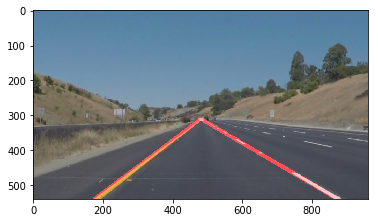

In [9]:

# Constants
kTestImagesRelativeInputPathDir = "test_images/"
kTestImagesRelativeOutputPathDir = "test_images_output/"
kTestVideosRelativeInputPathDir = "test_videos/"
kTestVideosRelativeOutputPathDir = "test_videos_output/"

# Global variable(s)

global_previous_left_lane_bottom_roi_intersection_point = (0,0)
global_previous_right_lane_bottom_roi_intersection_point = (0,0)

# This boolean is used to determine if we need to produce intermediate image artifacts, after each processing operation like Gray Scaling etc.
generateIntermediateArtifacts = False

# Helper method(s)
def get_region_of_interest_vertices(image):
    xsize = image.shape[1]
    ysize = image.shape[0]
    y_offset = 42
    left_bottom = [120, ysize]
    right_bottom = [850, ysize]
    left_top = [480, ysize/2 + y_offset]
    right_top = [490, ysize/2 + y_offset]
    region_of_interest_vertices = np.array([[left_top,right_top,right_bottom,left_bottom]], dtype=np.int32)
    return region_of_interest_vertices

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
        
 try:
    global global_previous_left_lane_bottom_roi_intersection_point
    global global_previous_right_lane_bottom_roi_intersection_point
    leftLaneLineMaxLength = 0
    rightLaneLineMaxLength = 0
    longestLeftLaneLine = (0,0,0,0)
    longestRightLaneLine = (0,0,0,0)

    for line in lines:
        for x1,y1,x2,y2 in line:
            dy = y2 - y1
            dx = x2 - x1
            slope = dy / dx
            lineLength = sqrt(dy**2 + dx**2)
            
            if slope < 0:
               if(lineLength > leftLaneLineMaxLength):
                    leftLaneLineMaxLength = lineLength
                    longestLeftLaneLine = line
                    
            else:
               if(lineLength > rightLaneLineMaxLength):
                    rightLaneLineMaxLength = lineLength
                    longestRightLaneLine = line                
    
    region_of_interest_vertices = get_region_of_interest_vertices(img)
    region_of_interest_left_top = region_of_interest_vertices[0][0]
    region_of_interest_right_top = region_of_interest_vertices[0][1]
    region_of_interest_right_bottom = region_of_interest_vertices[0][2]
    region_of_interest_left_bottom = region_of_interest_vertices[0][3]
    
    region_of_interest_top_line = get_line(region_of_interest_left_top, region_of_interest_right_top)
    region_of_interest_bottom_line = get_line(region_of_interest_left_bottom, region_of_interest_right_bottom)

    longest_left_lane_line = get_line([longestLeftLaneLine[0][0],longestLeftLaneLine[0][1]],[longestLeftLaneLine[0][2],longestLeftLaneLine[0][3]])
    
    longest_right_lane_line = get_line([longestRightLaneLine[0][0],longestRightLaneLine[0][1]],[longestRightLaneLine[0][2],longestRightLaneLine[0][3]])
    
    top_left_intersection_point = intersection(region_of_interest_top_line, longest_left_lane_line)
    bottom_left_intersection_point = intersection(region_of_interest_bottom_line, longest_left_lane_line)    
    if global_previous_left_lane_bottom_roi_intersection_point == (0,0):
        global_previous_left_lane_bottom_roi_intersection_point = bottom_left_intersection_point
        
    top_right_intersection_point = intersection(region_of_interest_top_line, longest_right_lane_line)
    bottom_right_intersection_point = intersection(region_of_interest_bottom_line, longest_right_lane_line)
    if global_previous_right_lane_bottom_roi_intersection_point == (0,0):
        global_previous_right_lane_bottom_roi_intersection_point = bottom_right_intersection_point
    
    if (top_left_intersection_point and bottom_left_intersection_point and top_right_intersection_point and bottom_right_intersection_point):
        cv2.line(img, tuple(top_left_intersection_point), tuple(global_previous_left_lane_bottom_roi_intersection_point), color, thickness)
        cv2.line(img, tuple(top_right_intersection_point), tuple(global_previous_right_lane_bottom_roi_intersection_point), color, thickness)

      
 except TypeError: 
        print("Ignoring sporadic type error as noise.")
    
def get_line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return (int(x),int(y))
    else:
        return False

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1, λ=0):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    currentTime = datetime.datetime.now()
    currentTimeString = str(currentTime)
    # Important to not modify the original image, but instead work on it's copy
    original_image_copy = np.copy(image)
    greyscale_image = grayscale(original_image_copy)    
    gaussian_blurred_image = gaussian_blur(greyscale_image,5)
    canny_image = canny(gaussian_blurred_image,50,150)
    
    xsize = canny_image.shape[1]
    ysize = canny_image.shape[0]
    y_offset = 42
    left_bottom = [120, ysize]
    right_bottom = [850, ysize]
    left_top = [480, ysize/2 + y_offset]
    right_top = [490, ysize/2 + y_offset]
    region_of_interest_vertices = np.array([[left_top,right_top,right_bottom,left_bottom]], dtype=np.int32)
    region_of_interest_image = region_of_interest(canny_image,region_of_interest_vertices)
    hough_lines_image = hough_lines(region_of_interest_image, 2, np.pi/180, 15, 4, 10)
    original_image_overlaid_with_lanes = weighted_img(hough_lines_image,original_image_copy)
    
    if generateIntermediateArtifacts == True:
        original_image_copy_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_1_original_image_copy.jpg" 
        plt.imshow(original_image_copy,cmap='gray')
        plt.savefig(original_image_copy_filename)
        
        greyscale_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_2_grayscale_image.jpg" 
        plt.imshow(greyscale_image,cmap='gray')
        plt.savefig(greyscale_image_filename)
        
        gaussian_blurred_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_3_gaussian_blurred_image.jpg" 
        plt.imshow(gaussian_blurred_image,cmap='gray')
        plt.savefig(gaussian_blurred_image_filename)
        
        canny_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_4_canny_image.jpg" 
        plt.imshow(canny_image,cmap='gray')
        plt.savefig(canny_image_filename)
        
        region_of_interest_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_5_region_of_interest_image.jpg" 
        plt.imshow(region_of_interest_image,cmap='gray')
        plt.savefig(region_of_interest_image_filename)
        
        hough_lines_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_6_hough_lines_image.jpg" 
        plt.imshow(hough_lines_image,cmap='gray')
        plt.savefig(hough_lines_image_filename)       

    return original_image_overlaid_with_lanes

# # Using the Pipeline above to process image(s)
generateIntermediateArtifacts = False
testImagesInputDirectory = os.listdir(kTestImagesRelativeInputPathDir)
for imageFile in testImagesInputDirectory:
    if '.jpg' in imageFile:
        global_previous_left_lane_bottom_roi_intersection_point = (0,0)
        global_previous_right_lane_bottom_roi_intersection_point = (0,0)
        input_file_relative_path = kTestImagesRelativeInputPathDir + imageFile
        output_file_relative_path = kTestImagesRelativeOutputPathDir + imageFile
        image_with_detected_lanes = process_image(mpimg.imread(input_file_relative_path))
        plt.imshow(image_with_detected_lanes)
        plt.savefig(output_file_relative_path)

# # Using the Pipeline above to process video(s)
generateIntermediateArtifacts = False
testVideosInputDirectory = os.listdir(kTestVideosRelativeInputPathDir)
for videoFile in testVideosInputDirectory:
       if '.mp4' in videoFile:
           global_previous_left_lane_bottom_roi_intersection_point = (0,0)
           global_previous_right_lane_bottom_roi_intersection_point = (0,0)
           input_videofile_relative_path = kTestVideosRelativeInputPathDir + videoFile
           output_file_relative_path = kTestVideosRelativeOutputPathDir + videoFile
           input_clip = VideoFileClip(input_videofile_relative_path)
           output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
           %time output_clip.write_videofile(output_file_relative_path, audio=False)

